# DC-GAN - Type 2 - Diabetic Retinopathy

In [1]:
import os
import sys
import glob
import json
import random
import argparse
import subprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
os.environ[ "CUDA_VISIBLE_DEVICES" ]="4"

In [4]:
seed = 963
random.seed(seed)
torch.manual_seed(seed)

### Hyperparameters

In [5]:
params = {
    "bsize" : 8, # Batch size during training.
    'imsize' : 360, # Spatial size of training images.
    'nc' : 3, # Number of channles in the training images.
    'nz' : 100, # Size of the Z latent vector.
    'ngf' : 32, # Size of feature maps in the generator.
    'ndf' : 64, # Size of features maps in the discriminator.
    'nepochs' : 125, # Number of training epochs.
    'lr' : 0.0002, # Learning rate for optimizers
    'beta1' : 0.5, # Beta1 hyperparam for Adam optimizer
    'save_epoch' : 5 # Save step.
}

### Data Loader

In [6]:
root = './dataset/dcgan_v3/train2'

def load_dataset(params):
    # Data proprecessing.
    
    transform = transforms.Compose([
        transforms.Resize(params['imsize']),
        transforms.CenterCrop(params['imsize']),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5))])

    dataset = dset.ImageFolder(root=root, transform=transform)

    dataloader = torch.utils.data.DataLoader(dataset,
        batch_size=params['bsize'],
        shuffle=True, num_workers= 16)

    return dataloader

In [7]:
device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")

### Training Samples

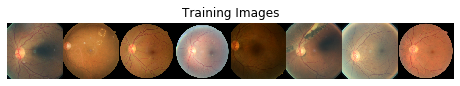

In [8]:
dataloader = load_dataset(params)

sample_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
   sample_batch[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

## Discriminator, Generator & Parameter Definitions

In [9]:
def weights_init(w):
    classname = w.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(params['nz'], params['ngf']*8*2,
            kernel_size=5, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(params['ngf']*8*2)
        
        self.tconv2 = nn.ConvTranspose2d(params['ngf']*8*2, params['ngf']*4*2,
            5, 3, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ngf']*4*2)

        self.tconv3 = nn.ConvTranspose2d(params['ngf']*4*2, params['ngf']*2*2,
            5, 3, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ngf']*2*2)

        self.tconv4 = nn.ConvTranspose2d(params['ngf']*2*2, params['ngf']*2,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ngf']*2)

        self.tconv5 = nn.ConvTranspose2d(params['ngf']*2, params['ngf'],
            4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(params['ngf'])

        self.tconv7 = nn.ConvTranspose2d(params['ngf'], params['nc'],
            4, 2, 1, bias=False)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        x = F.relu(self.bn5(self.tconv5(x)))
        x = F.tanh(self.tconv7(x))
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.conv1 = nn.Conv2d(params['nc'], params['ndf'],
            4, 2, 1, bias=False)

        self.conv2 = nn.Conv2d(params['ndf'], params['ndf']*2,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ndf']*2)

        self.conv3 = nn.Conv2d(params['ndf']*2, params['ndf']*4,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ndf']*4)

        self.conv4 = nn.Conv2d(params['ndf']*4, params['ndf']*8,
            5, 3, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ndf']*8)

        self.conv5 = nn.Conv2d(params['ndf']*8, params['ndf']*16,
            5, 3, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(params['ndf']*16)

        self.conv6 = nn.Conv2d(params['ndf']*16, 1, 5, 1, 0, bias=False)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2, True)
        x = F.sigmoid(self.conv6(x))

        return x

In [12]:
netG = Generator(params).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv7): ConvTranspose2d(32, 3, kernel_size=(4, 4), 

In [13]:
netD = Discriminator(params).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
)


In [14]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)

real_label = 1
fake_label = 0

In [15]:
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))

In [16]:
# Stores generated images as training progresses.
img_list = []

# Stores generator losses during training.
G_losses = []

# Stores discriminator losses during training.
D_losses = []

iters = 0

## Training

In [17]:
print("Starting Training Loop...")
print("-"*25)

for epoch in range(params['nepochs']):
    batches_done = 0
    for i, data in enumerate(dataloader, 0):
        batches_done +=1
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        
        netD.zero_grad()
        label = torch.full((b_size, ), real_label, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, params['nz'], 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(fake_label  )
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()
        
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()

        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, params['nepochs'], i+1, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 250 == 0) or ((epoch == params['nepochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_data = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_data, padding=2, normalize=True))

        iters += 1

    if epoch % params['save_epoch'] == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/type2/model_epoch_{}.pth'.format(epoch+1))

Starting Training Loop...
-------------------------


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/125][1/662]	Loss_D: 1.3101	Loss_G: 19.7691	D(x): 0.6118	D(G(z)): 0.5416 / 0.0000
[1/125][101/662]	Loss_D: 0.0007	Loss_G: 14.0797	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[1/125][201/662]	Loss_D: 0.2074	Loss_G: 4.0461	D(x): 0.9091	D(G(z)): 0.0616 / 0.0201
[1/125][301/662]	Loss_D: 0.0799	Loss_G: 5.2941	D(x): 0.9623	D(G(z)): 0.0383 / 0.0114
[1/125][401/662]	Loss_D: 1.0360	Loss_G: 3.8426	D(x): 0.8523	D(G(z)): 0.3787 / 0.0371
[1/125][501/662]	Loss_D: 0.4298	Loss_G: 2.8202	D(x): 0.7742	D(G(z)): 0.1103 / 0.1073
[1/125][601/662]	Loss_D: 0.1078	Loss_G: 4.1363	D(x): 0.9713	D(G(z)): 0.0719 / 0.0229
[2/125][1/662]	Loss_D: 0.3359	Loss_G: 3.4540	D(x): 0.8464	D(G(z)): 0.1351 / 0.0417
[2/125][101/662]	Loss_D: 2.3942	Loss_G: 8.2292	D(x): 0.9383	D(G(z)): 0.8611 / 0.0012
[2/125][201/662]	Loss_D: 0.5130	Loss_G: 6.2676	D(x): 0.9678	D(G(z)): 0.3594 / 0.0026
[2/125][301/662]	Loss_D: 0.2094	Loss_G: 5.0206	D(x): 0.9475	D(G(z)): 0.1325 / 0.0078
[2/125][401/662]	Loss_D: 0.7246	Loss_G: 2.6325	D(x): 0.5670	D(G(z))

[14/125][601/662]	Loss_D: 0.0264	Loss_G: 14.7952	D(x): 0.9752	D(G(z)): 0.0005 / 0.0003
[15/125][1/662]	Loss_D: 0.0009	Loss_G: 9.0514	D(x): 0.9999	D(G(z)): 0.0008 / 0.0010
[15/125][101/662]	Loss_D: 0.0339	Loss_G: 6.3549	D(x): 0.9740	D(G(z)): 0.0072 / 0.0049
[15/125][201/662]	Loss_D: 0.0108	Loss_G: 7.6312	D(x): 1.0000	D(G(z)): 0.0105 / 0.0054
[15/125][301/662]	Loss_D: 0.0157	Loss_G: 6.0548	D(x): 0.9997	D(G(z)): 0.0146 / 0.0293
[15/125][401/662]	Loss_D: 0.0282	Loss_G: 5.2197	D(x): 0.9997	D(G(z)): 0.0265 / 0.0067
[15/125][501/662]	Loss_D: 0.0377	Loss_G: 6.2675	D(x): 0.9998	D(G(z)): 0.0354 / 0.0062
[15/125][601/662]	Loss_D: 0.0308	Loss_G: 11.3402	D(x): 0.9985	D(G(z)): 0.0262 / 0.0001
[16/125][1/662]	Loss_D: 0.0126	Loss_G: 5.4698	D(x): 1.0000	D(G(z)): 0.0124 / 0.0234
[16/125][101/662]	Loss_D: 0.7044	Loss_G: 9.9610	D(x): 0.5729	D(G(z)): 0.0000 / 0.0198
[16/125][201/662]	Loss_D: 0.0661	Loss_G: 6.9176	D(x): 0.9946	D(G(z)): 0.0551 / 0.0025
[16/125][301/662]	Loss_D: 0.0013	Loss_G: 9.6424	D(x): 0.

[28/125][401/662]	Loss_D: 0.0086	Loss_G: 7.1547	D(x): 0.9975	D(G(z)): 0.0060 / 0.0041
[28/125][501/662]	Loss_D: 0.0147	Loss_G: 8.2820	D(x): 0.9998	D(G(z)): 0.0143 / 0.0020
[28/125][601/662]	Loss_D: 0.0115	Loss_G: 8.7207	D(x): 1.0000	D(G(z)): 0.0113 / 0.0022
[29/125][1/662]	Loss_D: 0.0057	Loss_G: 10.0606	D(x): 1.0000	D(G(z)): 0.0056 / 0.0119
[29/125][101/662]	Loss_D: 0.0007	Loss_G: 13.0877	D(x): 0.9997	D(G(z)): 0.0004 / 0.0003
[29/125][201/662]	Loss_D: 0.0013	Loss_G: 9.7716	D(x): 0.9993	D(G(z)): 0.0006 / 0.0001
[29/125][301/662]	Loss_D: 0.0900	Loss_G: 9.9475	D(x): 1.0000	D(G(z)): 0.0671 / 0.0003
[29/125][401/662]	Loss_D: 0.0248	Loss_G: 10.4652	D(x): 1.0000	D(G(z)): 0.0229 / 0.0031
[29/125][501/662]	Loss_D: 1.6883	Loss_G: 0.3687	D(x): 0.3738	D(G(z)): 0.0005 / 0.7333
[29/125][601/662]	Loss_D: 0.0063	Loss_G: 10.8588	D(x): 0.9944	D(G(z)): 0.0007 / 0.0002
[30/125][1/662]	Loss_D: 0.0049	Loss_G: 7.1317	D(x): 1.0000	D(G(z)): 0.0048 / 0.0036
[30/125][101/662]	Loss_D: 0.0007	Loss_G: 10.1258	D(x):

[42/125][101/662]	Loss_D: 0.0026	Loss_G: 9.6472	D(x): 1.0000	D(G(z)): 0.0026 / 0.0002
[42/125][201/662]	Loss_D: 0.0736	Loss_G: 9.7853	D(x): 1.0000	D(G(z)): 0.0636 / 0.0001
[42/125][301/662]	Loss_D: 0.0000	Loss_G: 13.1480	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[42/125][401/662]	Loss_D: 0.0254	Loss_G: 8.7596	D(x): 0.9822	D(G(z)): 0.0064 / 0.0033
[42/125][501/662]	Loss_D: 0.0948	Loss_G: 19.9448	D(x): 0.9162	D(G(z)): 0.0000 / 0.0000
[42/125][601/662]	Loss_D: 0.0102	Loss_G: 9.6832	D(x): 1.0000	D(G(z)): 0.0100 / 0.0023
[43/125][1/662]	Loss_D: 0.0007	Loss_G: 10.6197	D(x): 0.9999	D(G(z)): 0.0006 / 0.0004
[43/125][101/662]	Loss_D: 0.0022	Loss_G: 12.0591	D(x): 0.9982	D(G(z)): 0.0004 / 0.0004
[43/125][201/662]	Loss_D: 0.0003	Loss_G: 11.3413	D(x): 1.0000	D(G(z)): 0.0003 / 0.0002
[43/125][301/662]	Loss_D: 0.0016	Loss_G: 12.5935	D(x): 1.0000	D(G(z)): 0.0016 / 0.0013
[43/125][401/662]	Loss_D: 0.0447	Loss_G: 9.6004	D(x): 0.9622	D(G(z)): 0.0011 / 0.0005
[43/125][501/662]	Loss_D: 0.0003	Loss_G: 13.5671	D

[55/125][501/662]	Loss_D: 0.0209	Loss_G: 8.9262	D(x): 0.9806	D(G(z)): 0.0003 / 0.0003
[55/125][601/662]	Loss_D: 0.0000	Loss_G: 13.3192	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[56/125][1/662]	Loss_D: 0.2657	Loss_G: 10.0223	D(x): 1.0000	D(G(z)): 0.1392 / 0.0010
[56/125][101/662]	Loss_D: 0.2390	Loss_G: 21.9411	D(x): 0.8830	D(G(z)): 0.0000 / 0.0000
[56/125][201/662]	Loss_D: 0.0143	Loss_G: 20.4944	D(x): 1.0000	D(G(z)): 0.0137 / 0.0041
[56/125][301/662]	Loss_D: 0.0218	Loss_G: 9.4752	D(x): 0.9999	D(G(z)): 0.0206 / 0.0013
[56/125][401/662]	Loss_D: 0.2505	Loss_G: 5.2215	D(x): 0.8912	D(G(z)): 0.0099 / 0.0099
[56/125][501/662]	Loss_D: 0.0006	Loss_G: 9.1231	D(x): 1.0000	D(G(z)): 0.0006 / 0.0005
[56/125][601/662]	Loss_D: 0.0067	Loss_G: 7.4338	D(x): 0.9999	D(G(z)): 0.0065 / 0.0015
[57/125][1/662]	Loss_D: 0.7819	Loss_G: 21.6908	D(x): 1.0000	D(G(z)): 0.3465 / 0.0000
[57/125][101/662]	Loss_D: 0.0053	Loss_G: 12.2973	D(x): 1.0000	D(G(z)): 0.0052 / 0.0013
[57/125][201/662]	Loss_D: 0.0001	Loss_G: 16.1401	D(x

[69/125][201/662]	Loss_D: 0.0015	Loss_G: 11.4711	D(x): 1.0000	D(G(z)): 0.0015 / 0.0014
[69/125][301/662]	Loss_D: 0.0080	Loss_G: 10.9566	D(x): 1.0000	D(G(z)): 0.0078 / 0.0040
[69/125][401/662]	Loss_D: 0.0108	Loss_G: 9.7941	D(x): 1.0000	D(G(z)): 0.0106 / 0.0029
[69/125][501/662]	Loss_D: 0.0644	Loss_G: 8.8440	D(x): 1.0000	D(G(z)): 0.0566 / 0.0006
[69/125][601/662]	Loss_D: 0.0303	Loss_G: 13.1972	D(x): 0.9719	D(G(z)): 0.0000 / 0.0000
[70/125][1/662]	Loss_D: 0.0319	Loss_G: 10.1290	D(x): 0.9720	D(G(z)): 0.0008 / 0.0017
[70/125][101/662]	Loss_D: 0.0005	Loss_G: 18.7987	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[70/125][201/662]	Loss_D: 0.0015	Loss_G: 11.8323	D(x): 1.0000	D(G(z)): 0.0015 / 0.0012
[70/125][301/662]	Loss_D: 0.0001	Loss_G: 13.6798	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[70/125][401/662]	Loss_D: 0.0043	Loss_G: 15.4367	D(x): 0.9962	D(G(z)): 0.0005 / 0.0004
[70/125][501/662]	Loss_D: 0.0000	Loss_G: 18.0633	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[70/125][601/662]	Loss_D: 0.0401	Loss_G: 6.6036

[82/125][601/662]	Loss_D: 0.0003	Loss_G: 11.7355	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[83/125][1/662]	Loss_D: 0.0004	Loss_G: 9.7825	D(x): 0.9998	D(G(z)): 0.0002 / 0.0003
[83/125][101/662]	Loss_D: 0.0001	Loss_G: 19.0648	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[83/125][201/662]	Loss_D: 0.0018	Loss_G: 9.2851	D(x): 1.0000	D(G(z)): 0.0018 / 0.0015
[83/125][301/662]	Loss_D: 0.0061	Loss_G: 19.4947	D(x): 1.0000	D(G(z)): 0.0060 / 0.0010
[83/125][401/662]	Loss_D: 0.6396	Loss_G: 15.4076	D(x): 0.7624	D(G(z)): 0.0000 / 0.0003
[83/125][501/662]	Loss_D: 0.0035	Loss_G: 17.9376	D(x): 1.0000	D(G(z)): 0.0035 / 0.0019
[83/125][601/662]	Loss_D: 0.0029	Loss_G: 24.4797	D(x): 0.9971	D(G(z)): 0.0000 / 0.0000
[84/125][1/662]	Loss_D: 0.0003	Loss_G: 14.9153	D(x): 1.0000	D(G(z)): 0.0003 / 0.0001
[84/125][101/662]	Loss_D: 0.0000	Loss_G: 16.6577	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[84/125][201/662]	Loss_D: 0.0172	Loss_G: 6.6916	D(x): 0.9957	D(G(z)): 0.0123 / 0.0274
[84/125][301/662]	Loss_D: 0.0024	Loss_G: 16.2740	D

[96/125][301/662]	Loss_D: 0.3923	Loss_G: 21.3490	D(x): 0.8748	D(G(z)): 0.0093 / 0.0096
[96/125][401/662]	Loss_D: 0.4768	Loss_G: 18.9240	D(x): 1.0000	D(G(z)): 0.2593 / 0.0000
[96/125][501/662]	Loss_D: 0.0154	Loss_G: 8.0009	D(x): 1.0000	D(G(z)): 0.0147 / 0.0060
[96/125][601/662]	Loss_D: 0.0009	Loss_G: 8.1204	D(x): 1.0000	D(G(z)): 0.0009 / 0.0008
[97/125][1/662]	Loss_D: 0.0155	Loss_G: 12.9300	D(x): 0.9850	D(G(z)): 0.0000 / 0.0000
[97/125][101/662]	Loss_D: 0.0017	Loss_G: 27.5205	D(x): 0.9984	D(G(z)): 0.0000 / 0.0000
[97/125][201/662]	Loss_D: 0.0004	Loss_G: 10.2768	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[97/125][301/662]	Loss_D: 0.0088	Loss_G: 7.2049	D(x): 1.0000	D(G(z)): 0.0085 / 0.0039
[97/125][401/662]	Loss_D: 0.1105	Loss_G: 6.6168	D(x): 1.0000	D(G(z)): 0.0888 / 0.0150
[97/125][501/662]	Loss_D: 0.0014	Loss_G: 10.3411	D(x): 0.9988	D(G(z)): 0.0002 / 0.0002
[97/125][601/662]	Loss_D: 0.0004	Loss_G: 9.2536	D(x): 1.0000	D(G(z)): 0.0004 / 0.0002
[98/125][1/662]	Loss_D: 0.0015	Loss_G: 9.8575	D(x)

[111/125][301/662]	Loss_D: 0.0230	Loss_G: 7.5569	D(x): 0.9979	D(G(z)): 0.0201 / 0.0199
[111/125][401/662]	Loss_D: 0.0084	Loss_G: 6.4117	D(x): 1.0000	D(G(z)): 0.0083 / 0.0040
[111/125][501/662]	Loss_D: 0.0004	Loss_G: 9.0058	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[111/125][601/662]	Loss_D: 0.0002	Loss_G: 16.1726	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[112/125][1/662]	Loss_D: 0.0006	Loss_G: 8.9548	D(x): 1.0000	D(G(z)): 0.0006 / 0.0003
[112/125][101/662]	Loss_D: 0.0002	Loss_G: 10.4005	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[112/125][201/662]	Loss_D: 0.3010	Loss_G: 13.6353	D(x): 1.0000	D(G(z)): 0.1762 / 0.0008
[112/125][301/662]	Loss_D: 0.0000	Loss_G: 31.8538	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[112/125][401/662]	Loss_D: 1.3434	Loss_G: 4.3429	D(x): 0.6714	D(G(z)): 0.0004 / 0.1979
[112/125][501/662]	Loss_D: 0.0000	Loss_G: 33.3427	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[112/125][601/662]	Loss_D: 0.0058	Loss_G: 14.3659	D(x): 1.0000	D(G(z)): 0.0058 / 0.0033
[113/125][1/662]	Loss_D: 0.0000	Loss_G:

[124/125][601/662]	Loss_D: 0.0000	Loss_G: 31.5552	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[125/125][1/662]	Loss_D: 0.0022	Loss_G: 15.0614	D(x): 1.0000	D(G(z)): 0.0022 / 0.0015
[125/125][101/662]	Loss_D: 0.0002	Loss_G: 15.3696	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[125/125][201/662]	Loss_D: 0.0002	Loss_G: 10.1937	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[125/125][301/662]	Loss_D: 0.0027	Loss_G: 16.1050	D(x): 0.9973	D(G(z)): 0.0000 / 0.0000
[125/125][401/662]	Loss_D: 7.6178	Loss_G: 0.0088	D(x): 0.0027	D(G(z)): 0.0342 / 0.9914
[125/125][501/662]	Loss_D: 0.0000	Loss_G: 15.6502	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[125/125][601/662]	Loss_D: 0.0000	Loss_G: 18.3798	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


In [18]:
# Final Trained Model.

torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/type2/model_final.pth')

In [19]:
with open('model/type2/G_losses_type2.json', 'w') as f:
    json.dump(G_losses, f)

with open('model/type2/D_losses_type2.json', 'w') as f:
    json.dump(D_losses, f)

### Discriminator vs Generator Loss Plot

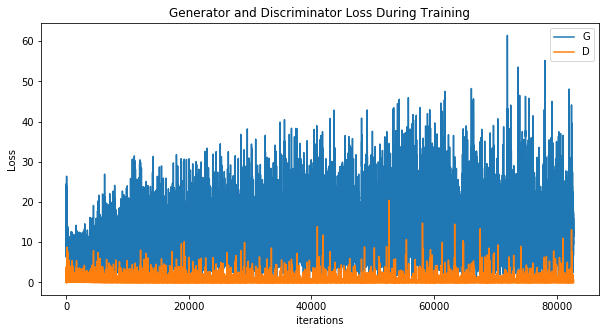

In [21]:
# Plot the Training Losses.

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('./generated_images/type2/discriminator_generator_loss_plot_type2.png')
plt.show()

## Sample Generation from Trained Model

### Sample from each Epochs

In [20]:
with tqdm(params['nepochs']) as pbar:
    for epoch in range(0,params['nepochs'],5):
        path = f'model/type2/model_epoch_{epoch+1}.pth'
        state_dict = torch.load(path,map_location='cpu')

        device = torch.device("cuda")
        params = state_dict['params']

        netG = Generator(params).to(device)
        netG.load_state_dict(state_dict['generator'])

        for i in range(10):
            noise = torch.randn(1, params['nz'], 1, 1, device=device)

            with torch.no_grad():
                generated_img = netG(noise).detach().cpu()

            image_data = np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0))
            plt.imsave(fname=f'./generated_images/type2/pic_generated_{epoch}_{i+1}.png', arr=np.asarray(image_data))
        pbar.update(5)

125it [00:41,  3.02it/s]


### Samples from Final Epoch

In [22]:
path = f'model/type2/model_final.pth'
state_dict = torch.load(path,map_location='cpu')
device = torch.device("cuda")
params = state_dict['params']

netG = Generator(params).to(device)
netG.load_state_dict(state_dict['generator'])

with tqdm(1000) as pbar:
    for i in range(1000):
        noise = torch.randn(1, params['nz'], 1, 1, device=device)
        with torch.no_grad():
            generated_img = netG(noise).detach().cpu()
        
        image_data = np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0))
        plt.imsave(fname=f'./generated_images/2_{i+1}.png', arr=np.asarray(image_data))
        pbar.update(1)

1000it [01:59,  8.35it/s]


### Learning Transitions across Epochs (Animation)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


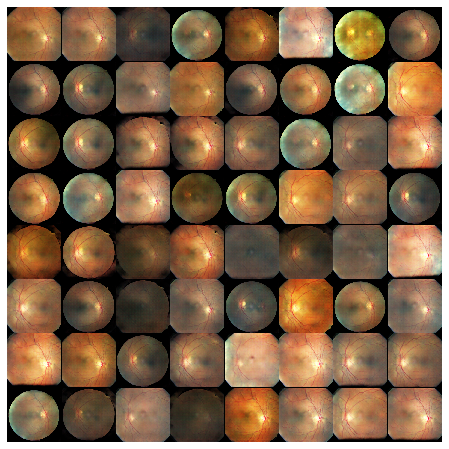

In [23]:
# Animation showing the overall improvements of the generator during the training.

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('./generated_images/type2/fundus_type2.gif', dpi=80, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


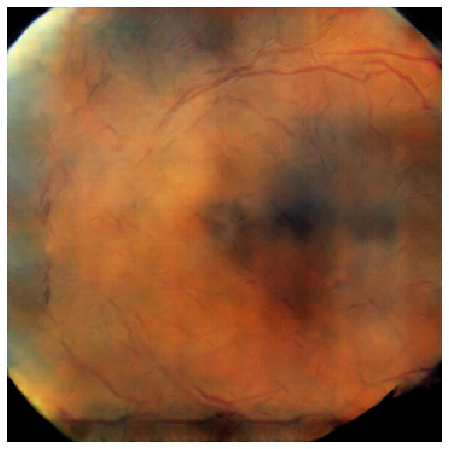

In [24]:
# Animation showing the improvements of the generator for across epoch from generated samples.

img_list = map(plt.imread, sorted(glob.glob('./generated_images/type2/*10.png')))
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('./generated_images/type2/fundus_type2_1.gif', dpi=80, writer='imagemagick')